# Heat Exposure Forecast (2024)

## Objective

This notebook aims to show forecasted exposure to heat in South Asia.

Inspired by [Anticipatory Action](https://www.anticipation-hub.org/about/what-is-anticipatory-action), this notebook uses global forecasts (.25° resolution) from [ECMWF](https://www.ecmwf.int/) and global population hexagons (22km resolution) to show how many people are exposed to extreme heat.

To emphasise an extreme heat event, the forecast dates for this notebook have been set in the past. However, running this notebook periodically with the most up-to-date forecasts (explained below) allows for a reproducible early warning system for extreme heat exposure.

Running this notebook in a cloud environment like [JupyterHub](https://jupyter.org/hub) would allow for use in low-bandwidth environments, common in the humanitarian sector.

## Setup

### Install and import dependencies

In [1]:
import IPython
!python -m pip install ecmwf-opendata cfgrib httpx xarray ipyleaflet matplotlib geopandas lonboard numpy gzip
IPython.display.clear_output(wait=False)

In [2]:
# Data fetching and processing libraries
import httpx
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import gzip

# ECMWF data fetching library
from ecmwf.opendata import Client

# Visualization libraries
from ipywidgets import FloatRangeSlider, jsdlink

from lonboard import Map, PolygonLayer, basemap
from lonboard.colormap import apply_continuous_cmap
from lonboard.controls import MultiRangeSlider
from lonboard.layer_extension import DataFilterExtension

from palettable.colorbrewer.sequential import OrRd_9

## Loading ECMWF high-resolution open forecast data

_See [this notebook](https://github.com/ecmwf/notebook-examples/blob/master/opencharts/medium-2t-long-probability.ipynb) and others for more examples._

For this step, we want to fetch temperature data. Specifically, [2m temperatures](https://codes.ecmwf.int/grib/param-db/167).

Next, let's request the 2m temperature data.

In [3]:
import os

directory = "temp-data"

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory '{directory}' created successfully!")
else:
    print(f"Directory '{directory}' already exists.")


Directory 'temp-data' already exists.


In [4]:
client = Client("ecmwf", beta=True)

# "2t" is 2m temperature (https://codes.ecmwf.int/grib/param-db/167)

parameters = ['2t']
filename = 'temp-data/forecast-2t.grib2'

# 2m temperature forecast for the next 300 hours, in 6h increments. This will take less than a minute to run and will download ~30Mb of data.

steps=list(range(0,300, 6))

client.retrieve(
    # no date & no time fetches the most recent forecast
    date="2024-05-21",
    # time=0,
    step=steps,
    stream="oper",
    type=['cf'],
    levtype="sfc",
    param='2t',
    target=filename
)

KeyboardInterrupt: 

_I'm having issues directly referencing the grib2 files stored on ecmwf's servers and accessing their steps, so I'll use ecdata to download the data (especially the 2m temperature data, which doesn't seem to be present in the .grib2 files stored on the server), save it, and then re-load it._

Temperature data is recorded in °K, which we should convert to °C 

In [5]:
data = xr.load_dataset("temp-data/forecast-2t.grib2", engine="cfgrib")

forecast = data - 273.15

### Inspect and visualize the forecast data

Visualizing the first forecast (step 0) gives us a visual overview of the data.

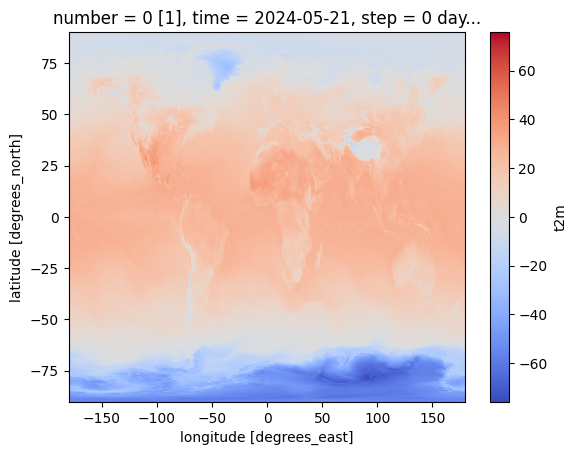

In [ ]:
forecast.t2m[0].plot(cmap=plt.cm.coolwarm)

We can also see temperature forecast data at a specific location (e.g., Lahore, Pakistan)

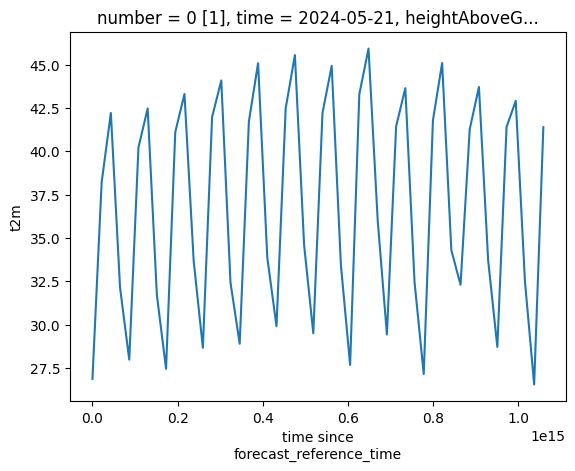

In [6]:
forecast.t2m.sel(longitude=74.3, latitude=31.6, method="nearest").plot()

## Define temperature threshold & bbox

We're not interested in temperatures below our threshold temperature, which is set at 30°C. We can define multiple thresholds, which can be used for visualization later.

In [7]:
# The hottest official temperature ever recorded is 56.7°C.
heat_levels = [30,35,40,45,50,57.5]

heat_min = min(heat_levels)
heat_max = max(heat_levels)

heat_mask = forecast.where(forecast >= heat_min)

For the purposes of this demo, we're only interested South Asia.

In [8]:
min_lon = 53.45
max_lon = 98.16
min_lat = 3.89
max_lat = 40.24

bbox=[min_lon, max_lon, min_lat, max_lat]
bbox

[53.45, 98.16, 3.89, 40.24]

In [9]:
mask_lon = (heat_mask.longitude >= min_lon) & (heat_mask.longitude <= max_lon)
mask_lat = (heat_mask.latitude >= min_lat) & (heat_mask.latitude <= max_lat)

In [10]:
south_asia_heat = heat_mask.where(mask_lon & mask_lat, drop=True)

Let's visualize our South Asia heat, with subplots for each forecast step (every 6 hours). Each row is a new day. 

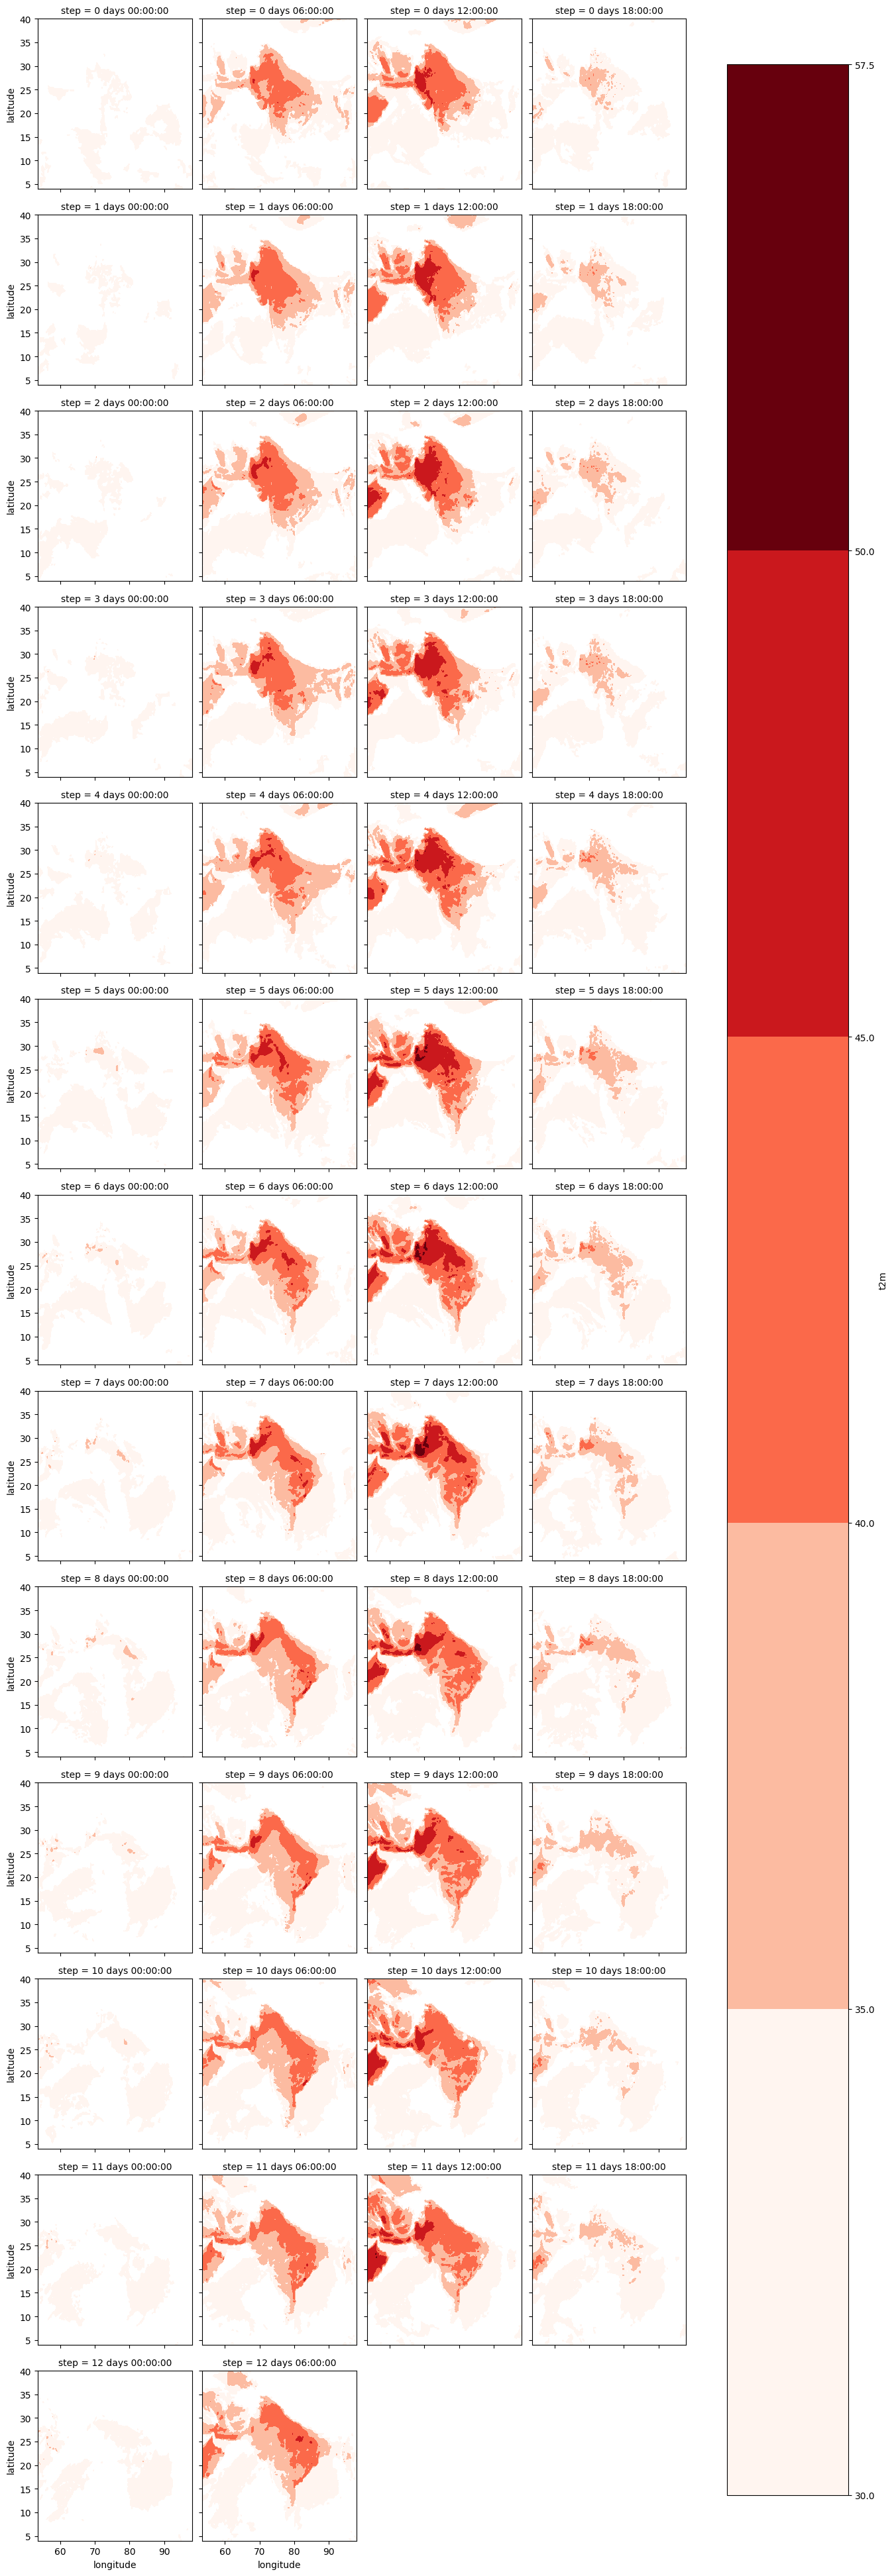

In [11]:
south_asia_heat.t2m.plot.contourf(col="step", col_wrap = 4, robust=True, vmin=25, levels=heat_levels, cmap=plt.cm.Reds)

It will be quite hot for the full range of this forecast, and extremely hot (>50°C) in some regions on days 6-8.

## Add Population Data

Heat by itself is interesting, but we are interested in peoples' _exposure_ to heat, so we need population data.

From HDX, [here](https://data.humdata.org/dataset/kontur-population-dataset-22km) is a 22km resolution hex bin dataset of global population data.

In [12]:
pop_url = "https://geodata-eu-central-1-kontur-public.s3.eu-central-1.amazonaws.com/kontur_datasets/kontur_population_20231101_r4.gpkg.gz"
query = {'raw': 'true'} 

response = httpx.get(pop_url, params=query)

In [14]:
with open('temp-data/pop_22km.gpkg.gz', "wb") as f:
    f.write(response.content)

In [15]:
with gzip.open("temp-data/pop_22km.gpkg.gz") as f:
    population = gpd.read_file(f)

We can drop population hexagons with fewer than 100 people per hexagon, which indicate very low population density.

In [16]:
pop_min = 100
pop_max = max(population["population"])

population.drop(population[population["population"] < 10].index, inplace=True)

### Geodataframe

Next, let's turn our forecast data into a Geodataframe. We can drop columns that aren't necessary for our analysis.

In [17]:
south_asia_heat_df = south_asia_heat.to_dataframe().dropna().drop(columns=["number","time","heightAboveGround"])
south_asia_heat_df = south_asia_heat_df.reset_index()


# this will allow us to filter our data visualization
south_asia_heat_df["time_delta"] = south_asia_heat_df["step"].dt.seconds


south_asia_heat_df.drop(columns="step")
south_asia_heat_df


,step,latitude,longitude,t2m,valid_time,time_delta
0,0 days 00:00:00,40.00,83.75,30.283966,2024-05-21 00:00:00,0
1,0 days 00:00:00,40.00,84.00,30.283966,2024-05-21 00:00:00,0
2,0 days 00:00:00,39.75,84.00,30.346466,2024-05-21 00:00:00,0
3,0 days 00:00:00,39.75,84.25,30.596466,2024-05-21 00:00:00,0
4,0 days 00:00:00,32.50,72.50,30.065216,2024-05-21 00:00:00,0
...,...,...,...,...,...,...
476042,12 days 06:00:00,4.00,94.75,30.402313,2024-06-02 06:00:00,21600
476043,12 days 06:00:00,4.00,95.00,30.058563,2024-06-02 06:00:00,21600
476044,12 days 06:00:00,4.00,96.25,30.058563,2024-06-02 06:00:00,21600
476045,12 days 06:00:00,4.00,96.50,32.683563,2024-06-02 06:00:00,21600


In [18]:
heat_gdf = gpd.GeoDataFrame(
    south_asia_heat_df, 
    geometry=gpd.points_from_xy(south_asia_heat_df.longitude, south_asia_heat_df.latitude),
    crs="EPSG:4326",
)

Next, let's join the temperature Geodataframe with the population geodataframe.

_This isn't the most correct way to do this. The weather forecast data is in .25x.25° grids, expressed as lat lon pairs. I'm using those lat lon pairs directly as point data and seeing if they fall within a population hex bin._


In [19]:
join = gpd.sjoin(
    population, 
    heat_gdf.to_crs("EPSG:3857"), 
    how="left",
    )

In [20]:
affected_heat = join.dropna().drop(columns=["h3", "index_right"]).reset_index()

Now that we have temperature forecast data added to our population data, we can see who will be affected by heat. We can group affected populations by temperature ranges (columns) and forecast times (rows).

In [21]:
# Inspired by: https://stackoverflow.com/questions/34317149/pandas-groupby-with-bin-counts

groups = affected_heat.groupby(['valid_time', pd.cut(affected_heat['t2m'], heat_levels)]).size().unstack()
groups

/var/folders/md/g6df9cs96bv_bv1kslvxkb4c0000gn/T/ipykernel_29997/2766002149.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = affected_heat.groupby(['valid_time', pd.cut(affected_heat['t2m'], heat_levels)]).size().unstack()


t2m,"(30.0, 35.0]","(35.0, 40.0]","(40.0, 45.0]","(45.0, 50.0]","(50.0, 57.5]"
valid_time,,,,,
2024-05-21 00:00:00,978,0,0,0,0
2024-05-21 06:00:00,3024,2585,1301,7,0
2024-05-21 12:00:00,2609,1943,2109,219,0
2024-05-21 18:00:00,3027,577,6,0,0
2024-05-22 00:00:00,956,1,0,0,0
2024-05-22 06:00:00,3018,2640,1607,37,0
2024-05-22 12:00:00,2492,2000,2060,472,0
2024-05-22 18:00:00,3058,836,11,0,0
2024-05-23 00:00:00,1279,1,0,0,0


## Visualizing the data

We can see the number of people affected above, but we want to know where they are located. Before we can map them, we need to prep the visualization.

In [22]:
# This creates a range from 0-1 to define our colormap.
normalized_heat = (affected_heat["t2m"] - heat_min) / (heat_max - heat_min)

colors = apply_continuous_cmap(normalized_heat, OrRd_9)

In [23]:
# This lets us have multiple data-drive sliders for interaction with the visualization

filter_extension = DataFilterExtension(filter_size=3)

In [24]:
# Defining our time ranges ranges.

step_min = affected_heat["time_delta"].min()
step_max = affected_heat["time_delta"].max()

In [25]:
filter_values = np.column_stack(
    [affected_heat["t2m"], affected_heat["population"], affected_heat["time_delta"]]
)
initial_filter_range = [
    [heat_min, heat_max],
    [pop_min, pop_max],
    [step_min, step_max]
]

Using Lonboard, we can visualize this large dataset easily. Using color to define temperature, and extrusion height for populations, we can see where the most people are effected by various levels of heat. We can define our "sliders" to filter the data, then render them below the map.

In [26]:
heat_slider = FloatRangeSlider(value=initial_filter_range[0], min=heat_min, max=heat_max, step=2.5, description="Heat: ")
population_slider = FloatRangeSlider(value=initial_filter_range[1], min=pop_min, max=pop_max, step=10000, description="Population: ")
step_slider = FloatRangeSlider(value=initial_filter_range[2], min=step_min, max=step_max, step=3600, description="Forecast: ")

multi_slider = MultiRangeSlider([heat_slider, population_slider, step_slider])

In [27]:
layer = PolygonLayer.from_geopandas(
    affected_heat,
    extensions=[filter_extension],
    get_fill_color=colors,
    extruded=True,
    get_elevation=affected_heat["population"],
    elevation_scale = 0.1,
    get_filter_value=filter_values,
    filter_range=initial_filter_range,
)

m = Map(
    layer,
    basemap_style = basemap.CartoBasemap.DarkMatter,
    )
m

/Users/zacdez/Library/Caches/pypoetry/virtualenvs/notebooks-sNYx7QfP-py3.12/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

These widgets let us interact with the data, so we can fine-tune our investigation.

In [28]:
multi_slider

MultiRangeSlider(children=(FloatRangeSlider(value=(30.0, 57.5), description='Heat: ', max=57.5, min=30.0, step…

In [29]:
_ = jsdlink((multi_slider, "value"), (layer, "filter_range"))

_The "Forecast" slider would be better off as a single variable `FloatSlider`, but I couldn't get that to work with the recommended `MultiRangeSlider`._

## Conclusion

In this notebook, we've automated the process of analyzing temperature forecasts with population data to see where people will be exposed to extreme heat in the near future.